In [2]:
import xarray as xr

file = "ERA5_TropicalPacific_Wind_Monthly_1980_2018.nc"

ds = xr.open_dataset(file)

ds

<xarray.Dataset> Size: 539MB
Dimensions:     (time: 468, latitude: 189, longitude: 761)
Coordinates:
  * time        (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2018-12-01
  * latitude    (latitude) float32 756B 23.5 23.25 23.0 ... -23.0 -23.25 -23.5
  * longitude   (longitude) float32 3kB 100.0 100.2 100.5 ... 289.5 289.8 290.0
Data variables:
    wind_speed  (time, latitude, longitude) float64 538MB ...

In [4]:
import xarray as xr

file = "fgco2_TropicalPacific_1980_2020.nc"

ds = xr.open_dataset(file)

ds

<xarray.Dataset> Size: 38MB
Dimensions:  (time: 492, lat: 48, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat      (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    fgco2    (time, lat, lon) float64 38MB ...
Attributes:
    description:  Tropical Pacific (100E–280E, 23.5S–23.5N), monthly fgco2, 1...
    source:       Derived from LDEO-HPD v2023 (Lamont-Doherty Earth Observatory)
    units:        mol/m²/yr (or dataset default)

In [9]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 MB 105.5 MB/s  0:00:010:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 161.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torchaudio]4 [torchaudio]]


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import *   # 如果不需要可以先保留，里面可能有 open_dataset 等工具

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


In [16]:
wind_path = "ERA5_TropicalPacific_Wind_Monthly_1980_2018.nc"
flux_path = "fgco2_TropicalPacific_1980_2020.nc"

# 1) 读风速
ds_wind = xr.open_dataset(wind_path)
ds_wind = ds_wind.rename({"latitude": "lat", "longitude": "lon"})
wind = ds_wind["wind_speed"]

# 2) 读 fgco2
ds_flux = xr.open_dataset(flux_path)
flux = ds_flux["fgco2"]

print("原始 wind time:", str(wind.time.min().values)[:10], "→", str(wind.time.max().values)[:10])
print("原始 flux time:", str(flux.time.min().values)[:10], "→", str(flux.time.max().values)[:10])

# 3) 只在 time 上取交集（wind 只到 2018-12）
t0 = max(wind.time.min(), flux.time.min())   # 1980-01-15
t1 = min(wind.time.max(), flux.time.max())   # 2018-12-01
wind = wind.sel(time=slice(t0, t1))
flux = flux.sel(time=slice(t0, t1))

print("slice 后 wind time:", str(wind.time.min().values)[:10], "→", str(wind.time.max().values)[:10])
print("slice 后 flux time:", str(flux.time.min().values)[:10], "→", str(flux.time.max().values)[:10])

# 4) 同时在 time, lat, lon 三个维度插值到 fgco2 的网格
wind_interp = wind.interp(
    time = flux.time,
    lat  = flux.lat,
    lon  = flux.lon
)

print("wind_interp shape:", wind_interp.shape)
print("flux shape:",        flux.shape)

# 5) 合并成 Dataset 再转 DataFrame
ds_all = xr.Dataset(
    {
        "wind_speed": wind_interp,
        "fgco2": flux,
    }
)

df = ds_all.to_dataframe().reset_index()
df = df.dropna(subset=["wind_speed", "fgco2"])

print(df.head())
print("Total samples:", df.shape)


原始 wind time: 1980-01-01 → 2018-12-01
原始 flux time: 1980-01-15 → 2020-12-15
slice 后 wind time: 1980-02-01 → 2018-12-01
slice 后 flux time: 1980-01-15 → 2018-11-15
wind_interp shape: (467, 48, 200)
flux shape: (467, 48, 200)
           time   lat    lon  wind_speed     fgco2
9600 1980-02-15 -23.5  100.5    8.257028 -0.670731
9601 1980-02-15 -23.5  101.5    8.223000 -0.607181
9602 1980-02-15 -23.5  102.5    8.230877 -0.523545
9603 1980-02-15 -23.5  103.5    8.272032 -0.383561
9604 1980-02-15 -23.5  104.5    8.173303 -0.241710
Total samples: (3585404, 5)


In [17]:
# 确保 time 是 datetime
df["time"] = pd.to_datetime(df["time"])

# 时间划分：1980–2010 训练，2011–2014 验证，2015–2018 测试
train_df = df[(df["time"] >= "1980-01-01") & (df["time"] < "2011-01-01")]
val_df   = df[(df["time"] >= "2011-01-01") & (df["time"] < "2015-01-01")]
test_df  = df[(df["time"] >= "2015-01-01") & (df["time"] < "2019-01-01")]  # 到 2018-12

print("Train samples:", len(train_df))
print("Val   samples:", len(val_df))
print("Test  samples:", len(test_df))

# 目前只用风速做输入特征（后面加 SST / dpCO2 就在这里扩展 feature_cols）
feature_cols = ["wind_speed"]

X_train = train_df[feature_cols].values.astype("float32")
y_train = train_df[["fgco2"]].values.astype("float32")

X_val   = val_df[feature_cols].values.astype("float32")
y_val   = val_df[["fgco2"]].values.astype("float32")

X_test  = test_df[feature_cols].values.astype("float32")
y_test  = test_df[["fgco2"]].values.astype("float32")

print("X_train / y_train:", X_train.shape, y_train.shape)
print("X_val   / y_val  :", X_val.shape,   y_val.shape)
print("X_test  / y_test :", X_test.shape,  y_test.shape)


Train samples: 2854474
Val   samples: 369312
Test  samples: 361618
X_train / y_train: (2854474, 1) (2854474, 1)
X_val   / y_val  : (369312, 1) (369312, 1)
X_test  / y_test : (361618, 1) (361618, 1)


In [18]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# 只用训练集拟合 scaler，避免信息泄漏
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train).astype("float32")
X_val_scaled   = scaler_X.transform(X_val).astype("float32")
X_test_scaled  = scaler_X.transform(X_test).astype("float32")

# 转成 tensor
X_train_t = torch.from_numpy(X_train_scaled)
y_train_t = torch.from_numpy(y_train)

X_val_t   = torch.from_numpy(X_val_scaled)
y_val_t   = torch.from_numpy(y_val)

X_test_t  = torch.from_numpy(X_test_scaled)
y_test_t  = torch.from_numpy(y_test)

# DataLoader
batch_size = 2048

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [19]:
class WindMLP(nn.Module):
    def __init__(self, in_dim=1, hidden1=32, hidden2=16, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim),
        )

    def forward(self, x):
        return self.net(x)

# in_dim 就等于特征个数，目前只有 wind_speed = 1
model = WindMLP(in_dim=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


WindMLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

Epoch 005 | train_loss=1.4686e+00 | val_loss=1.8795e+00
Epoch 010 | train_loss=1.4684e+00 | val_loss=1.8835e+00
Epoch 015 | train_loss=1.4684e+00 | val_loss=1.8803e+00
Epoch 020 | train_loss=1.4684e+00 | val_loss=1.8817e+00
Epoch 025 | train_loss=1.4684e+00 | val_loss=1.8838e+00
Epoch 030 | train_loss=1.4684e+00 | val_loss=1.8798e+00
Epoch 035 | train_loss=1.4684e+00 | val_loss=1.8811e+00
Epoch 040 | train_loss=1.4683e+00 | val_loss=1.8814e+00
Epoch 045 | train_loss=1.4683e+00 | val_loss=1.8777e+00
Epoch 050 | train_loss=1.4683e+00 | val_loss=1.8806e+00


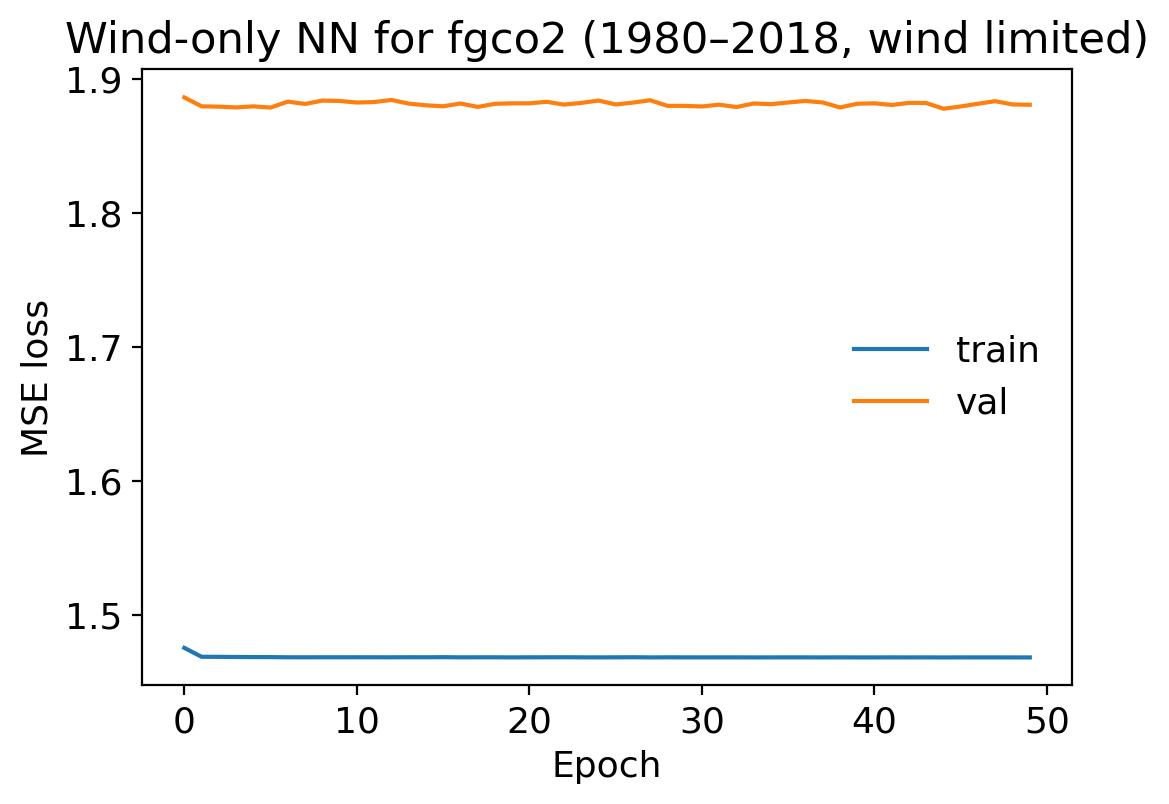

In [20]:
num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---------- Train ----------
    model.train()
    batch_train_losses = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)

    # ---------- Validation ----------
    model.eval()
    batch_val_losses = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            batch_val_losses.append(loss.item())

    val_loss = np.mean(batch_val_losses)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:03d} | train_loss={train_loss:.4e} | val_loss={val_loss:.4e}")

# 画 loss 曲线
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Wind-only NN for fgco2 (1980–2018, wind limited)")
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t.to(device)).cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2   = r2_score(y_test, y_pred_test)

print("Test period: 2015–2018")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²  : {r2:.44}")


Test period: 2015–2018
Test RMSE: 1.2526
Test R²  : 0.0322878360748291015625
